# TASK:

### Deadline: 17 martie ora 23:59.
### Formular pentru trimiterea temei: https://forms.gle/isPikzbiBdNm7AhA6

Vom folosi urmatorul dataset: https://www.kaggle.com/rmisra/news-category-dataset (headline-uri de stiri etichetate conform unei liste de categorii).

1. (optional) Intrucat setul de date contine multe categorii, puteti pastra exemplele din 4-5 clase (selectate de catre voi) si sa rezolvati problema de clasificare doar pentru aceste exemple
2. Incercati mai multe metode de preprocesare si tokenizare a textelor pentru a obtine reprezentari de tip Bag-of-Words (stergeti/nu stergeti stop words, lematizati sau aplicati stemming, pastrati sau eliminati punctuatia, normalizati folosind standardizare, L1, L2 sau Tf-Idf). Implementati **3** astfel de combinatii.
3. Impartiti setul de date in 80% train, 20% test, iar pentru fiecare metoda de preprocesare antrenati un model ales de voi (diferit de Decision Tree) pe datele de train
4. Evaluati modelul pe datele de test, determinand acuratete, precizie, recall, f1, si stabiliti care metoda de procesare a textelor a adus rezultate mai bune.
5. Determinati pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).
6. Folosind aceasta metoda de procesare a textelor, antrenati alte doua modele diferite la alegere si comparati performanta cu modelul original.
7. Pentru cel mai bun model afisati metricile la nivel de clasa (classification report) si matricea de confuzie.

In [32]:
from sys import platform, path
if platform == "linux" or platform == "linux2":
    path.append('/home/dariusbuhai/python/lib/python3.9/site-packages')
import json

In [33]:
# Load categories
categories = dict()
with open("data/News_Category_Dataset_v2.json", "r") as f:
    while True:
        line = f.readline()
        if line is None or line == '':
            break
        line_json = json.loads(line)
        if line_json['category'] not in categories:
            categories[line_json['category']] = [line_json]
        else:
            categories[line_json['category']].append(line_json)

1. (optional) Intrucat setul de date contine multe categorii, puteti pastra exemplele din 4-5 clase (selectate de catre voi) si sa rezolvati problema de clasificare doar pentru aceste exemple

In [34]:
categories = {x:categories[x] for x in list(categories.keys())[:5]}

In [35]:
import string
import re
import spacy
from nltk.stem.snowball import SnowballStemmer

nlp = spacy.load("en_core_web_md")
stemmer = SnowballStemmer(language='english')

def preprocess(word: str, use_steam=False):
    word = word.lower()
    if not use_steam:
        return word
    return stemmer.stem(word)

def tokenize(text: str, remove_punctuation=False, remove_stop_words=False, use_lemma=False):
    text = re.sub(r'http\S+', '', text)
    if remove_punctuation:
        text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    if remove_stop_words:
        actual_doc = []
        for token in doc:
            if token.text not in nlp.Defaults.stop_words and token.text != ' ':
                actual_doc.append(token)
        doc = actual_doc
    if use_lemma:
        return [token.lemma for token in doc]
    return [token.text for token in doc]

2. Incercati mai multe metode de preprocesare si tokenizare a textelor pentru a obtine reprezentari de tip Bag-of-Words (stergeti/nu stergeti stop words, lematizati sau aplicati stemming, pastrati sau eliminati punctuatia, normalizati folosind standardizare, L1, L2 sau Tf-Idf). Implementati **3** astfel de combinatii.

In [36]:
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def create_features(method="M1"):
    cv = None
    if method == "M1":
        cv = CountVectorizer(
            preprocessor=lambda x: preprocess(x, re),
            tokenizer=lambda x: tokenize(x, remove_punctuation=True, use_lemma=True),
            token_pattern=None,
            max_features=10
        )
    elif method == "M2":
        cv = CountVectorizer(
            preprocessor=lambda x: preprocess(x),
            tokenizer=lambda x: tokenize(x, remove_punctuation=True, remove_stop_words=True, use_lemma=True),
            token_pattern=None,
            max_features=10
        )
    elif method == "M3":
        cv = TfidfVectorizer(
            preprocessor=lambda x: preprocess(x, use_steam=True),
            tokenizer=lambda x: tokenize(x, remove_punctuation=True, remove_stop_words=True),
            token_pattern=None,
            max_features=10
        )
    X, y = None, None
    idx = 0
    for category in categories:
        texts = [x['headline'] for x in categories[category]]
        cv.fit(texts)
        features = cv.transform(texts)
        if method in ["M1", "M2"]:
            scaler = preprocessing.Normalizer(norm=('l1' if method == "M1" else "l2"))
            scaler.fit(features)
            features = scaler.transform(features)
        features = features.toarray()
        features = np.array(features, dtype=np.float64)
        if X is None:
            X = features
        else:
            X = np.concatenate((features, X), axis=0)
        results = np.array([idx for _ in range(features.shape[0])])
        if y is None:
            y = results
        else:
            y = np.concatenate((y, results))
        idx += 1
    return X, y

In [31]:
X1, y1 = create_features("M1")
print(X1.shape, y1.shape)
X2, y2 = create_features("M2")
print(X2.shape, y2.shape)
X3, y3 = create_features("M3")
print(X3.shape, y3.shape)

KeyboardInterrupt: 

In [ ]:
# Dump dataset to pickle
import pickle
dataset = {"X1": X1, "y1": y1, "X2": X2, "y2": y2, "X3": X3, "y3": y3}
pickle.dump(dataset, open("data/dataset.pck", "wb" ) )

In [37]:
# Load dataset from pickle
import pickle
dataset = pickle.load(open("data/dataset.pck", "rb" ))
X1, y1 = dataset['X1'], dataset['y1']
X2, y2 = dataset['X2'], dataset['y2']
X3, y3 = dataset['X3'], dataset['y3']

4. Evaluati modelul pe datele de test, determinand acuratete, precizie, recall, f1, si stabiliti care metoda de procesare a textelor a adus rezultate mai bune.

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

def test_dataset(X, y):
    # 3. Impartiti setul de date in 80% train, 20% test, iar pentru fiecare metoda de preprocesare antrenati un model ales de voi (diferit de Decision Tree) pe datele de train
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    rfc = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10)
    rfc.fit(x_train, y_train)
    y_test_predict = rfc.predict(x_test)
    print("Accuracy:", metrics.accuracy_score(y_test, y_test_predict))
    print("F1 (macro):", metrics.f1_score(y_test, y_test_predict, average="macro"))
    print("F1 (weighted):", metrics.f1_score(y_test, y_test_predict, average="weighted"))
    print()
    return rfc

In [44]:
# Accuracy: 0.5668
model1_1 = test_dataset(X1, y1)
# Best dataset (Accuracy: 0.6497)
model1_2 = test_dataset(X2, y2)
# Accuracy: 0.6312
model1_3 = test_dataset(X3, y3)

Accuracy: 0.6261237897648686
F1 (macro): 0.24302241016448564
F1 (weighted): 0.5524697643565729

Accuracy: 0.6604426002766252
F1 (macro): 0.2582817540356971
F1 (weighted): 0.5846714407862361

Accuracy: 0.6531811894882434
F1 (macro): 0.2539007648115087
F1 (weighted): 0.5766803558377018



5. Determinati pentru acest caz care au fost top 10 cele mai importante feature-uri (cuvinte).

Feature: 0, Score: 0.00043328906303962236
Feature: 1, Score: 0.049882772247104926
Feature: 2, Score: 0.0007163693257428726
Feature: 3, Score: 0.0005991881906769975
Feature: 4, Score: 0.0020803484373651563
Feature: 5, Score: 0.02960464042682042
Feature: 6, Score: 0.8749224307086783
Feature: 7, Score: 0.005093496974764294
Feature: 8, Score: 0.01214129780389581
Feature: 9, Score: 0.024526166821911687


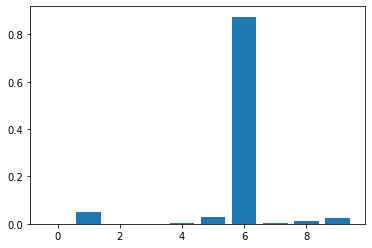

In [52]:
from matplotlib import pyplot as plt
importance = model1_2.feature_importances_
for i,v in enumerate(importance):
    print(f"Feature: {i}, Score: {v}")

plt.bar([x for x in range(len(importance))], importance)
plt.show()

6. Folosind aceasta metoda de procesare a textelor, antrenati alte doua modele diferite la alegere si comparati performanta cu modelul original.

In [54]:
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

def train_knc(x_train, x_test, y_train, y_test):
    knc = KNeighborsClassifier(5)
    knc.fit(x_train, y_train)
    y_test_predict = knc.predict(x_test)
    print("K Neighbors Classifier Accuracy:", metrics.accuracy_score(y_test, y_test_predict))
    return knc

def train_mlp(x_train, x_test, y_train, y_test):
    mlp = MLPClassifier(alpha=1, max_iter=1000)
    mlp.fit(x_train, y_train)
    y_test_predict = mlp.predict(x_test)
    print("MLP Classifier Accuracy:", metrics.accuracy_score(y_test, y_test_predict))
    return mlp

In [56]:
# 3. Impartiti setul de date in 80% train, 20% test, iar pentru fiecare metoda de preprocesare antrenati un model ales de voi (diferit de Decision Tree) pe datele de train
x_train, x_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2)
# Accuracy: 0.6502
model2 = train_knc(x_train, x_test, y_train, y_test)
# Best model: Accuracy: 0.6625
model3 = train_mlp(x_train, x_test, y_train, y_test)

K Neighbors Classifier Accuracy: 0.6502420470262794
MLP Classifier Accuracy: 0.6625172890733056


7. Pentru cel mai bun model afisati metricile la nivel de clasa (classification report) si matricea de confuzie.

In [57]:
def print_model_metrics(model, x_test, y_test):
    y_test_predict = model.predict(x_test)
    print(metrics.classification_report(y_test, y_test_predict, zero_division=True))
    cm = metrics.confusion_matrix(y_test, y_test_predict)
    sns.heatmap(cm, annot=True)

              precision    recall  f1-score   support

           0       1.00      0.00      0.00       669
           1       0.65      0.39      0.49      3211
           2       1.00      0.00      0.00       403
           3       1.00      0.00      0.00       689
           4       0.66      0.97      0.79      6596

    accuracy                           0.66     11568
   macro avg       0.86      0.27      0.26     11568
weighted avg       0.71      0.66      0.59     11568



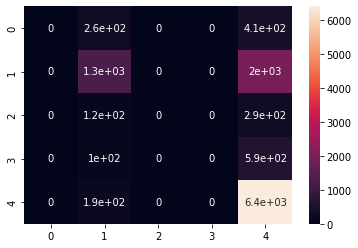

In [58]:
print_model_metrics(model3, x_test, y_test)